This notebook showcases how an LLM can generate PyDough queries from natural language instructions. The goal is to demonstrate how AI can automate complex data analysis, making querying faster, more intuitive, and accessible without needing deep technical expertise.

Each example highlights different capabilities, including aggregations, filtering, ranking, and calculations across multiple collections.

---
## Setup & Basic Usage of the API

First, we import the created client.

In [33]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env")
from pydough_analytics.llm.llm_client import LLMClient 

We can declare global definitions that will be useful for any question that needs them.

Then we initialize the client. We can select the provider and model based on the ones available for use, if none is provided then it will use Google and Gemini 2.5 Pro as default.

In [34]:
client = LLMClient(
    #provider="anthropic",
    #model="claude-sonnet-4-5@20250929"
)

One should use the `ask()` method to make a query to the model.

We get a `result` object with the next attributes: 

- `code`:  The PyDough query generated by the LLM.
- `sql`: The SQL equivalent of the generated PyDough query.
-  `df`:The dataframe containing the query results.
- `full_explanation`: An explanation of how the model solved the query.
- `exception`: Stores any errors encountered while executing the query.
- `original_question`: The natural language question input by the user.

---
## First query

Ask method asks a simple query (no discourse mode)

In [35]:
kg_path  = "../data/metadata/Tpch_graph.json"
md_path  = "../data/metadata_markdowns/Tpch.md"
db_name  = "TPCH"

db_config = {
    "engine":   "sqlite",
    "database": "../data/databases/TPCH.db"
}

question = "Give me the name of all the suppliers from the United States"

result = client.ask(
    question=question,
    kg_path=kg_path,
    db_config=db_config,
    md_path=md_path,
    db_name=db_name,
)

After that, we can consult all the necessary atributes from the result.

We can check the for the **pydough code** directly.

In [36]:
print(result.code)

us_suppliers = nations.WHERE(name == 'UNITED STATES').suppliers.CALCULATE(
    supplier_name=name
)


We can also get an **explanation** of how the model solved the query by the LLM.


In [37]:
print(result.full_explanation)

Based on your request, here is the PyDough code to retrieve the names of all suppliers from the United States.

### Explanation

1.  **`nations.WHERE(name == 'UNITED STATES')`**: This part of the code starts by accessing the `nations` collection and filters it to find the nation where the `name` is exactly 'UNITED STATES'.

2.  **`.suppliers`**: After filtering for the correct nation, it navigates to the `suppliers` sub-collection, which contains all suppliers associated with that nation.

3.  **`.CALCULATE(supplier_name=name)`**: Finally, it selects the `name` of each supplier and renames it to `supplier_name` for clarity in the final output.


And if we want to compare, we can get the **equivalent SQL query** created by Pydough.

In [38]:
print(result.sql)

SELECT
  supplier.s_name AS supplier_name
FROM main.nation AS nation
JOIN main.supplier AS supplier
  ON nation.n_nationkey = supplier.s_nationkey
WHERE
  nation.n_name = 'UNITED STATES'


If we want to visually check, analyze or edit the resulting **dataframe**, we also can. There is a dedicated section for this later. on the document

In [39]:
result.df

,supplier_name
0,Supplier#000000010
1,Supplier#000000019
2,Supplier#000000046
3,Supplier#000000049
4,Supplier#000000055
...,...
388,Supplier#000009819
389,Supplier#000009829
390,Supplier#000009859
391,Supplier#000009906


We can also check the original natural language **question** that was asked.

In [40]:
print(result.original_question)

Give me the name of all the suppliers from the United States


If there where to be an **exception** or **error** running the code we could also check that out and see what happened.

In [41]:
print(result.exception)

None


## Query correction (early preview)

To try to correct a response with execution problems in PyDough, we can use the `correct()` method. 

In [42]:
result = client.ask(
    kg_path=kg_path,
    db_config=db_config,
    md_path=md_path,
    db_name=db_name,
    question="For each of the 5 largest part sizes, find the part of that size with the highest retail price"
)

print(result.full_explanation)

Here is the PyDough code to solve the query:

### Explanation of the Code

1.  **`parts.PARTITION(name="size_groups", by=size)`**: The query begins by partitioning the `parts` collection based on the `size` attribute. This operation groups all parts of the same size together, creating a new collection where each record represents a unique size.

2.  **`.TOP_K(5, by=size.DESC())`**: From the collection of unique size groups, this function selects the top 5 groups corresponding to the 5 largest part sizes in descending order.

3.  **`.parts`**: This navigates into the sub-collection of parts associated with each of the top 5 size groups. The result is a collection containing all parts that belong to one of the five largest sizes, while retaining the context of which size group they belong to.

4.  **`.WHERE(RANKING(by=retail_price.DESC(), per="size_groups") == 1)`**: This step filters the parts. The `RANKING` function is used as a window function to rank parts within their respective siz

/home/esteban/pydough-ce/.venv/lib/python3.13/site-packages/pydough/sqlglot/sqlglot_relational_expression_visitor.py:216: UserWarning: PyDough when using SQLITE dialect does not support ascending ordering with nulls first (changed to nulls last)
  warnings.warn(


If one calls the dataframe and gets an error, no response, or a empty dataframe, it is possible that there is a PyDough exception. We can check this by running:

You can try to fix the error using the `correct` method. We are going to declare a new variable to obtain the corrected result. 

In [44]:
corrected_result = client.correct(
    result=result,
    kg_path=kg_path,
    db_config=db_config,
    md_path=md_path,
    db_name=db_name,
    context_data=None
)

To see how the model try to solve the issue, you can print the full explanation of the `corrected_result`.

In [45]:
print(corrected_result.full_explanation)

Here is the PyDough code to solve the query:

### Explanation of the Code

1.  **`parts.PARTITION(name="size_groups", by=size)`**: The query begins by partitioning the `parts` collection based on the `size` attribute. This operation groups all parts of the same size together, creating a new collection where each record represents a unique size.

2.  **`.TOP_K(5, by=size.DESC())`**: From the collection of unique size groups, this function selects the top 5 groups corresponding to the 5 largest part sizes in descending order.

3.  **`.parts`**: This navigates into the sub-collection of parts associated with each of the top 5 size groups. The result is a collection containing all parts that belong to one of the five largest sizes, while retaining the context of which size group they belong to.

4.  **`.WHERE(RANKING(by=retail_price.DESC(), per="size_groups") == 1)`**: This step filters the parts. The `RANKING` function is used as a window function to rank parts within their respective siz

---
## Post-processing dataframe

Once the DataFrame is generated, it can be analysed or manipulated just like any other dataframe, using **any** Python package for analysis, visualization, or transformation. 

This is a planned future feature, and one of the core differentiators of PyDough!

As a first example, in this section we manipulate a resulting dataframe with pandas and matplotlib to create a histogram and a boxplot of the different orders prices.

In [46]:
result = client.ask(
    kg_path=kg_path,
    db_config=db_config,
    md_path=md_path,
    db_name=db_name,
    question="Give me all the order prices, name the column total_price."
)

result.df

,total_price
0,173665.47
1,46929.18
2,193846.25
3,32151.78
4,144659.20
...,...
1499995,114856.68
1499996,68906.56
1499997,92750.90
1499998,63216.65


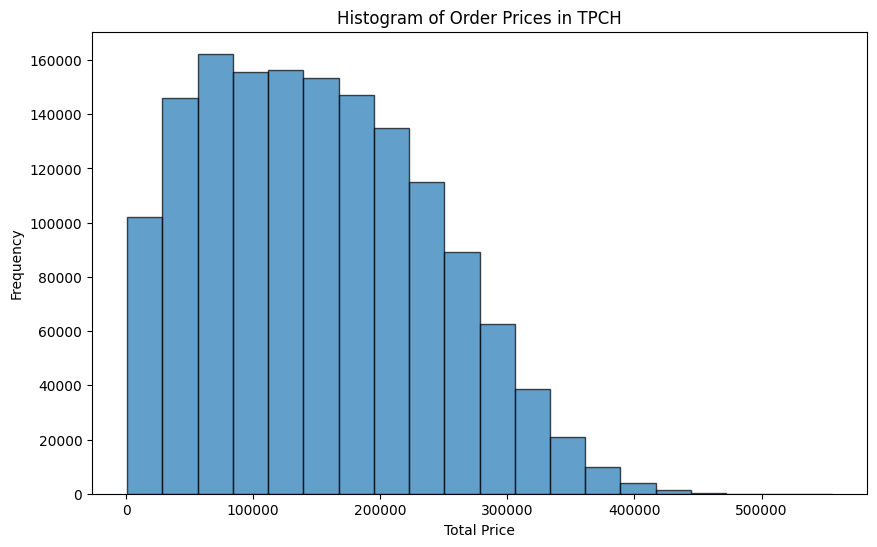

In [48]:
import matplotlib.pyplot as plt

df= result.df

plt.figure(figsize=(10, 6))
plt.hist(df["total_price"], bins=20, edgecolor="black", alpha=0.7)

plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.title("Histogram of Order Prices in TPCH")

plt.show()

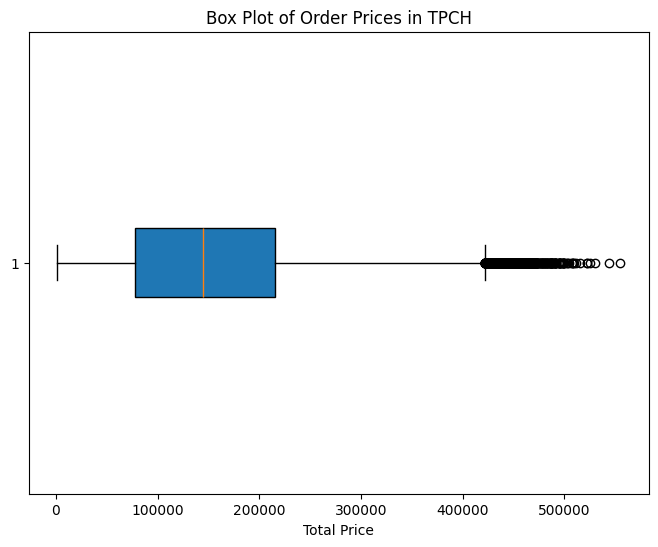

In [49]:
plt.figure(figsize=(8, 6))
plt.boxplot(df["total_price"], vert=False, patch_artist=True)


plt.xlabel("Total Price")
plt.title("Box Plot of Order Prices in TPCH")

# Show the plot
plt.show()

## Test Cases

Let's now look at a few more test cases and see how PyDough and PyDough LLM does.

### Customer Segmentation

### 1. Find the names of all customers and the number of orders placed in 1995 in Europe.

- Demonstrates simple filtering, counting, and sorting while being business-relevant for regional market analysis. 
- Adds a second filtering layer by including account balance and order activity, making it more dynamic.

In [57]:
query = "Find the names of all customers and the number of their orders placed in 1995 in Europe."

result = client.ask(
    kg_path=kg_path,
    db_config=db_config,
    md_path=md_path,
    db_name=db_name,
    question=query)

print(result.full_explanation)
result.df.head()

Based on your request, here is the PyDough code to find the names of all customers in Europe and the number of their orders placed in 1995.

### Explanation

1.  **`regions.WHERE(name == 'EUROPE')`**: This filters the `regions` collection to select only the 'EUROPE' region.

2.  **`.nations.customers`**: From the filtered region, it navigates down to access all customers belonging to the nations within Europe.

3.  **`.WHERE(HAS(orders.WHERE(YEAR(order_date) == 1995)) == 1)`**: This filters the customers to include only those who have placed at least one order in the year 1995. The inner `WHERE` filters the orders by year, and `HAS` checks for their existence.

4.  **`.CALCULATE(...)`**: This step processes the filtered customers to produce the final output.

*   `customer_name=name`: Selects the customer's name.

*   `num_orders_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995))`: Counts the number of orders for each customer that were placed specifically in 1995.


,customer_name,num_orders_1995
0,Customer#000000011,1
1,Customer#000000020,3
2,Customer#000000026,2
3,Customer#000000031,5
4,Customer#000000043,2


**Follow up**: Now, give me the ones who have an account balance greater than $700 and placed at least one order in that same year. Sorted in descending order by the number of orders.

In [58]:
discourse = client.discourse(result, 
"Now, give me the ones who have an account balance greater than $700 and placed at least one order in that same year. \
Sorted in descending order by the number of orders.")

result2 = client.ask(
    kg_path=kg_path,
    db_config=db_config,
    md_path=md_path,
    db_name=db_name,
    question=discourse)

print(result2.full_explanation)
result2.df.head()

Based on your follow-up question, here is the PyDough code to retrieve the European customers who had an account balance greater than $700 and placed at least one order in 1995, sorted by their order count.

### Explanation of the Code

1.  **`regions.WHERE(name == 'EUROPE').nations.customers`**: This part of the query starts by filtering the `regions` collection to select only 'EUROPE', then navigates through the associated `nations` to access all `customers` within that region.

2.  **`.WHERE((account_balance > 700) & (HAS(orders.WHERE(YEAR(order_date) == 1995)) == 1))`**: This is the filtering step applied to the European customers. It includes only those who meet two conditions:

*   `account_balance > 700`: The customer's account balance is greater than $700.

*   `HAS(orders.WHERE(YEAR(order_date) == 1995)) == 1`: The customer has placed at least one order in the year 1995.

3.  **`.CALCULATE(...)`**: This step calculates the two required fields for the output:

*   `customer_nam

,customer_name,num_orders_1995
0,Customer#000107440,12
1,Customer#000014920,11
2,Customer#000079606,11
3,Customer#000108496,11
4,Customer#000009019,10


In [59]:
print(result2.exception)

None


### 2. List customers who ordered in 1996 but not in 1997, with a total spent of over 1000$?

- Showcases PyDough’s HAS() and HASNOT() functions, helping analyze customer retention and spending patterns. 
- Also incorporates a time-based calculation.

In [60]:
query = "List customers who ordered in 1996 but not in 1997 with a total spent of over $1000."

result = client.ask(
    kg_path=kg_path,
    db_config=db_config,
    md_path=md_path,
    db_name=db_name,
    question=query
)

print(result.full_explanation)
result.df.head()

Based on your request, here is the PyDough code to list customers who placed orders in 1996 but not in 1997, and whose total spending exceeds $1000.

### Explanation

1.  **`customers.WHERE(...)`**: The query starts by filtering the `customers` collection based on a set of conditions.

2.  **`HAS(orders.WHERE(YEAR(order_date) == 1996)) == 1`**: This condition checks if a customer has at least one order placed in the year 1996.

3.  **`HASNOT(orders.WHERE(YEAR(order_date) == 1997)) == 1`**: This condition ensures that the customer has no orders placed in the year 1997.

4.  **`SUM(orders.total_price) > 1000`**: This condition calculates the total amount spent by each customer by summing the `total_price` of all their orders and checks if it is greater than $1000.

5.  **`.CALCULATE(customer_name=name)`**: After filtering, this selects the `name` of each customer who meets all the specified criteria and renames it to `customer_name`.


,customer_name
0,Customer#000000005
1,Customer#000000017
2,Customer#000000020
3,Customer#000000031
4,Customer#000000038


**Follow up**: Now, include the number of months since the last order and sort by total spent, highest first.

In [61]:
discourse = client.discourse(result,
"Now, include the number of months since the last order and sort by total spent, highest first.")

result2 = client.ask(
    kg_path=kg_path,
    db_config=db_config,
    md_path=md_path,
    db_name=db_name,
    question=discourse)

print(result2.full_explanation)
result2.df.head()

Of course. Here is the updated query to include the number of months since the last order and sort the results by total spending.

### Explanation

This query builds upon the previous logic with the following steps:

1.  **Initial Filtering**: It starts by filtering the `customers` collection to find those who placed at least one order in 1996 and no orders in 1997, using `HAS` and `HASNOT` respectively.

2.  **Calculate Metrics**: For this filtered set of customers, it then uses `CALCULATE` to compute three new fields:

*   `customer_name`: The customer's name.

*   `total_spent`: The sum of `total_price` for all of the customer's orders.

*   `last_order_date`: The most recent `order_date` from all of the customer's orders, found using `MAX`.

3.  **Filter by Spending**: A `WHERE` clause is applied to filter out customers whose `total_spent` is not greater than 1000.

4.  **Final Calculation and Selection**: Another `CALCULATE` is used to:

*   Compute `months_since_last_order` by us

,customer_name,total_spent,months_since_last_order
0,Customer#000001948,5614411.17,328
1,Customer#000047401,5262679.14,330
2,Customer#000094354,5234152.55,327
3,Customer#000120877,5200194.28,327
4,Customer#000012595,4973507.88,327


### Sales Performance

### 3. Find the region with the highest total order value in 1996.

- The total order value is defined as potential revenue, defined as the sum of extended_price * (1 - discount)
- It introduces precise calculations within the query, ensuring revenue insights.

In [62]:
client.add_definition("Revenue is defined as the sum of quantity * extended_price * (1 - discount) * (1 + tax).")

In [63]:
query = "Find the region with the highest revenue in 1996."

result = client.ask(
    kg_path=kg_path,
    db_config=db_config,
    md_path=md_path,
    db_name=db_name,
    question=query
)

print(result.full_explanation)
result.df.head()

Based on your request, here is the PyDough code to find the region with the highest revenue in 1996.

### Explanation

1.  **`regions.CALCULATE(...)`**: The query starts from the `regions` collection, as we want to calculate a value for each region.

2.  **`region_name=name`**: Inside `CALCULATE`, we select the `name` of the region and rename it to `region_name` for the output.

3.  **`total_revenue=SUM(...)`**: We create a new field called `total_revenue`. Its value is calculated by summing the `total_price` of orders.

4.  **`nations.customers.orders`**: To get to the orders, we traverse the database relationships from `regions` through `nations` and `customers`.

5.  **`.WHERE(YEAR(order_date) == 1996)`**: We filter the orders to include only those placed in the year 1996.

6.  **`.TOP_K(1, by=total_revenue.DESC())`**: Finally, this function sorts the regions by the calculated `total_revenue` in descending order (`DESC()`) and selects the top one, effectively giving us the region wi

,region_name,total_revenue
0,EUROPE,7.015421e+09


**Follow up**: Can you compare it now year over year **in that region**?

In [ ]:
discourse = client.discourse(result, "Can you compare it now year over year in that region?")

result2 = client.ask(
    kg_path=kg_path,
    db_config=db_config,
    md_path=md_path,
    db_name=db_name,
    question=discourse
)

print(result2.full_explanation)
result2.df.head()

Based on your previous query, you identified 'EUROPE' as the region with the highest revenue in 1996. To compare the revenue year over year for that specific region, we will filter for 'EUROPE' and then group the orders by year to calculate the total revenue for each year.

### Explanation

1.  **`regions.WHERE(name == 'EUROPE')`**: This filters the `regions` collection to select only the 'EUROPE' region.

2.  **`.nations.customers.orders`**: This navigates from the 'EUROPE' region down to all associated orders through the `nations` and `customers` collections.

3.  **`.CALCULATE(order_year=YEAR(order_date))`**: For each order, it creates a new field named `order_year` by extracting the year from the `order_date`.

4.  **`.PARTITION(name='yearly_orders', by=(order_year))`**: This groups all the orders from the 'EUROPE' region by the `order_year` we just calculated.

5.  **`.CALCULATE(year=order_year, total_revenue=SUM(orders.total_price))`**: For each yearly group created by the partit

,year,total_revenue
0,1992,6.926705e+09
1,1993,6.911395e+09
2,1994,6.979473e+09
3,1995,6.970001e+09
4,1996,7.015421e+09


### Product Trends

### 4. Which 10 customers purchased the highest quantity of products during 1998?

- Highlights ranking queries, customer segmentation, and purchasing trends. 

In [65]:
query = "Which 10 customers purchased the highest quantity of products during 1998?."

result = client.ask(
    kg_path=kg_path,
    db_config=db_config,
    md_path=md_path,
    db_name=db_name,
    question=query
)

print(result.full_explanation)
result.df

Based on your request, here is the PyDough code snippet to find the 10 customers who purchased the highest quantity of products in 1998.

### Explanation of the Code

1.  **`customers.CALCULATE(...)`**: The query starts with the `customers` collection. The `CALCULATE` function is used to create new fields for each customer.

2.  **`customer_name=name`**: This selects the customer's `name` and renames it to `customer_name` for the output.

3.  **`total_quantity=SUM(...)`**: This calculates the total quantity of products purchased by each customer in 1998.

*   **`orders.WHERE(YEAR(order_date) == 1998)`**: It first accesses the `orders` for each customer and filters them to include only those placed in the year 1998.

*   **`.lines.quantity`**: From these filtered orders, it navigates to the associated `lines` and accesses the `quantity` for each line item.

*   **`SUM(...)`**: The `SUM` function aggregates the `quantity` from all line items of all filtered orders for that customer, resu

,customer_name,total_quantity
0,Customer#000119539,1206
1,Customer#000026518,1158
2,Customer#000024877,1104
3,Customer#000000019,1084
4,Customer#000106000,1058
5,Customer#000102295,1029
6,Customer#000027970,995
7,Customer#000053383,994
8,Customer#000099025,988
9,Customer#000137437,987


**Follow up**: Now return the sum of only the products that have "green" on the product name.

In [66]:
discourse = client.discourse(result, """Now take into account only the products that have "green" in their name""")

result2 = client.ask(
    kg_path=kg_path,
    db_config=db_config,
    md_path=md_path,
    db_name=db_name,
    question=discourse
)

print(result2.full_explanation)
result2.df

Of course. Here is the PyDough code to find the top 10 customers who purchased the highest quantity of products with "green" in their name during 1998.

### Explanation

1.  **`customers.CALCULATE(...)`**: We start with the `customers` collection and use `CALCULATE` to compute new fields for each customer.

2.  **`customer_name=name`**: We select the customer's `name` and rename it to `customer_name` for the output.

3.  **`total_quantity=SUM(...)`**: We calculate the total quantity of products purchased by each customer that meets the specified criteria.

4.  **`orders.WHERE(YEAR(order_date) == 1998)`**: Inside the `SUM` aggregation, we first navigate to the customer's `orders` and filter them to include only those placed in the year 1998.

5.  **`.lines.WHERE(CONTAINS(part.name, "green"))`**: For the orders from 1998, we access their `lines` and add a new filter to only include line items where the associated part's `name` contains the string "green".

6.  **`.quantity`**: We select 

,customer_name,total_quantity
0,Customer#000011509,208
1,Customer#000022147,201
2,Customer#000027577,201
3,Customer#000109117,176
4,Customer#000016252,172
5,Customer#000009139,171
6,Customer#000099187,170
7,Customer#000024817,164
8,Customer#000112678,162
9,Customer#000072490,158
